# Supervised learning surrogate model for indentation

A surrogate model based on support vector regression (SVR) is trained for two important results of cyclic indentations: (i) the hysteresis width in the force-displacement curve, and (ii) the creep length during the holding stage of the indentation. The training data is obtained from finite element (FE) simulations of the indentation process with a given indeter shape and a fixed loading scenario, where the applied force-time curve is given. The material parameters, representing the feature vector for the supervised learning, are varied in a wide range to obtain data representing the relation between material parameters and indentation results. The importance of optimizing the SVR hyperparameters and of selecting material parameters with a significant correlation to the indentation result is demonstrated.

Authors: Alexander Hartmaier, Ziba Hamzeh, Pardis Nooshmehr</br>
Institution: ICAMS, Ruhr-Universität Bochum, Germany</br>
Date: July 2021

This work is licensed under a Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">(CC-BY-NC-SA)</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

Supervised learning algorithms from the scikit-learn.platform are applied, see https://scikit-learn.org/stable/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

"""Functions for statistical evaluation of training success"""
def my_scorer_cv(scorer, X_train, y_train, exponentiate=False):
    scorer.fit(X_train, y_train)
    kfold=KFold(n_splits=5, shuffle=True, random_state=rndstate)
    scores = cross_val_score(scorer,X_train,y_train,cv=kfold)*100.0
    print('Cross-validation scores [%]: {}\n'.format(scores))
    print('Average cross-validation score: {} %\n\n'.format(scores.mean()))

def my_scorer_test(scorer, X_train,X_test, y_train, y_test, exponentiate=False):
    scorer.fit(X_train, y_train)
    train_score = 100*scorer.score(X_train, y_train)
    test_score = 100*scorer.score(X_test, y_test)
    print("Training set score: {} %".format(train_score))
    print("Test set score: {} %".format(test_score))

def my_scorer(regressor):
    """
    Score a given regressor on both train and test datasets,
    calculate metrics (RMSE, MAE, R2)
    and plot true-vs-predicted values.
    
    Parameters:
    -----------
    regressor - a sklearn-compatible regressor that has .predict method
    
    """
    pred_train = regressor.predict(X_train)
    pred_test = regressor.predict(X_test)
    print("Train data:")
    print("RMSE = ",np.sqrt(mean_squared_error(y_train,pred_train)))
    print("MAE = ",mean_absolute_error(y_train,pred_train))
    print("R2 = ",r2_score(y_train,pred_train))
    
    print("Test data:")
    print("RMSE = ",np.sqrt(mean_squared_error(y_test,pred_test)))
    print("MAE = ",mean_absolute_error(y_test,pred_test))
    print("R2 = ",r2_score(y_test,pred_test))

# Read data from FE simulations

In [2]:
#loading data with pandas
AllData = pd.read_csv('../data/identation_database.csv')
AllData['width']    *= 1000
AllData['pile_up']  *= 1000
AllData['x_pileup'] *= 1000
AllData['clength']  *= 1000
AllData.dropna(inplace=True)

scaler = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scaler.fit(AllData)
# apply transform
AllData= scaler.transform(AllData)
# create DataFrame
AllData=pd.DataFrame(AllData,columns=['0', 'n', 'm', 'A','A0', 'C1', 'g1', 'C2', 'Q', 'b',
       'pile_up', 'width', 'depth', 'displacement', 'x_pileup', 'x_intersect',
       'hys_width', 'fd-slope', 'x_fmax', 'hist_lowest', 'clength'])
AllData = AllData.drop(columns=['0'])
print('Database with scaled values')
AllData.head()

Database with scaled values


,n,m,A,A0,C1,g1,C2,Q,b,pile_up,width,depth,displacement,x_pileup,x_intersect,hys_width,fd-slope,x_fmax,hist_lowest,clength
0,-0.819978,-0.041610,-0.767446,-0.862661,0.526179,-0.904,0.990648,0.992,-0.333333,-0.911488,-0.911488,-0.914583,-0.914635,-0.192733,-0.914568,-0.687026,0.843169,-0.907958,-0.922999,-0.890361
1,0.085130,0.109816,-0.999822,-0.783594,0.906198,-0.128,0.206858,0.320,-1.000000,-0.757874,-0.757874,-0.747295,-0.747947,-0.434634,-0.747475,-0.828619,0.591013,-0.745594,-0.712078,-0.809361
2,0.157263,-0.174697,-0.999657,-0.447853,-0.568668,-0.328,0.963483,0.088,-0.777778,-0.710840,-0.710840,-0.385545,-0.385926,0.389246,-0.385521,-0.083634,0.108700,-0.373831,-0.497014,-0.550389
3,0.349760,0.213105,-0.999975,-0.693874,-0.338070,-0.776,0.340013,0.152,0.777778,-0.570167,-0.570167,-0.336710,-0.337466,-0.022874,-0.356519,-0.369544,0.052683,-0.324321,-0.386183,-0.733232
4,0.057915,-0.829897,-0.999476,-0.822710,0.690601,0.080,0.617902,-0.184,-1.000000,-0.781930,-0.781930,-0.712087,-0.712695,-0.133359,-0.712173,-0.644390,0.518530,-0.695259,-0.701610,-0.833049


# Suport Vector Regression (SVR)

In [3]:
# define parameters for hyperparamater tuning
C = [x for x in np.linspace(start = 0.001, stop = 100, num = 100)]
kernel = ['linear', 'rbf', 'poly', 'sigmoid']
degree = [int(x) for x in np.linspace(start = 1, stop =20, num = 10)]
gamma = ['scale', 'auto']
coef0 = [x for x in np.linspace(start = 0.001, stop = 1, num = 100)]
epsilon = [x for x in np.linspace(start = 0.001, stop = 1, num = 100)]
random_grid = {'C': C,
               'kernel': kernel,
               'degree': 
               degree,
               'gamma': gamma,
               'coef0': coef0,
               'epsilon':epsilon,
                #'shrinking':shrinking,
              }

#define material parameters as input
InNames = ['n','m','A0','C1', 'g1', 'C2','Q','b']
input_data = AllData[InNames]
print('Feature vector for training (material paramaters)')
input_data.head()

Feature vector for training (material paramaters)


,n,m,A0,C1,g1,C2,Q,b
0,-0.819978,-0.041610,-0.862661,0.526179,-0.904,0.990648,0.992,-0.333333
1,0.085130,0.109816,-0.783594,0.906198,-0.128,0.206858,0.320,-1.000000
2,0.157263,-0.174697,-0.447853,-0.568668,-0.328,0.963483,0.088,-0.777778
3,0.349760,0.213105,-0.693874,-0.338070,-0.776,0.340013,0.152,0.777778
4,0.057915,-0.829897,-0.822710,0.690601,0.080,0.617902,-0.184,-1.000000


# Train SVR for hysteresis width 

## 1. Training with arbitrary hyperparameters

--Cross-validation--

Cross-validation scores [%]: [88.94869539 90.2728439  89.86585768]

Average cross-validation score: 89.69579898867039 %


training model

Training set score: 89.89812287759527 %
Test set score: 89.28040658913267 %


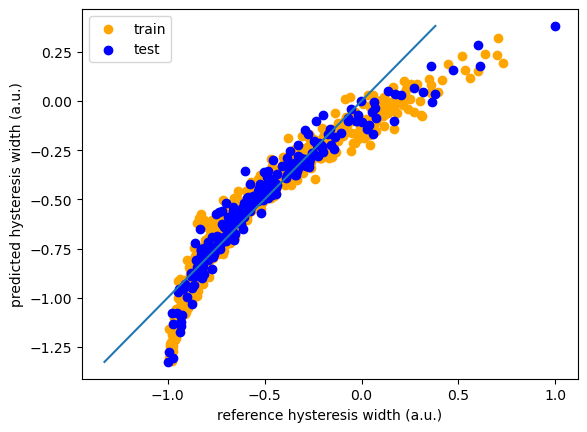

Cross-validation scores [%]: [87.85512803 90.15104203 90.35332237 90.1593432  89.47627927]

Average cross-validation score: 89.59902298093331 %


Training set score: 89.89812287759527 %
Test set score: 89.28040658913267 %
Train data:
RMSE =  0.11451876655894361
MAE =  0.08027789650809332
R2 =  0.8989812287759528
Test data:
RMSE =  0.11401942904975042
MAE =  0.0758304801377493
R2 =  0.8928040658913267


In [4]:
#select hysteresis width as label (training target)
output_data = AllData['hys_width']

# Preprocessing data
rndstate = 40
#Splitting into training and test set
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, random_state=rndstate)

svr = SVR(C=10 ,coef0=0.889, degree=9, epsilon=0.001, gamma='scale',
    kernel='linear')

# Cross-Validation
print('--Cross-validation--\n')
kfold=KFold(n_splits=3, shuffle=True, random_state=rndstate)
scores = cross_val_score(svr,X_train,y_train,cv=kfold)*100.0
print('Cross-validation scores [%]: {}\n'.format(scores))
print('Average cross-validation score: {} %\n\n'.format(scores.mean()))

print('training model\n')
#fit SVR model to training data
svr.fit(X_train, y_train)
#compute traning and test scores and print them to terminal
train_score = 100*svr.score(X_train, y_train)
test_score = 100*svr.score(X_test, y_test)
print("Training set score: {} %".format(train_score))
print("Test set score: {} %".format(test_score))

#graphical output
y_predict_test=svr.predict(X_test)
y_predict_train=svr.predict(X_train)
y_predict = svr.predict(input_data)

y_max = max(y_predict_test)
y_min = min(y_predict_test)
plt.plot([y_min,y_max],[y_min,y_max])
plt.scatter(y_train,y_predict_train,c='orange',label='train')
plt.scatter(y_test,y_predict_test,c='b',label='test')
plt.legend()
plt.xlabel('reference hysteresis width (a.u.)')
plt.ylabel('predicted hysteresis width (a.u.)')
plt.show()

#calculate statistical data for success of training
my_scorer_cv(svr, X_train=X_train, y_train=y_train, exponentiate=False)   
my_scorer_test(svr, X_train=X_train,X_test=X_test, y_train=y_train, y_test=y_test, exponentiate=False)
my_scorer(svr)

## 2. Hyperparameter optimization with randomized search

In [5]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
svr = SVR()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
svr_random = RandomizedSearchCV(estimator = svr, param_distributions = random_grid,
                               n_iter = 82, cv = 10, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
svr_random.fit(X_train, y_train)

print('Optimal hyperparameters for SVR:')
hyper = svr_random.best_params_
hyper

Fitting 10 folds for each of 82 candidates, totalling 820 fits
Optimal hyperparameters for SVR:


{'kernel': 'rbf',
 'gamma': 'auto',
 'epsilon': np.float64(0.011090909090909092),
 'degree': 1,
 'coef0': np.float64(0.28354545454545454),
 'C': np.float64(22.223000000000003)}

--Cross-validation--

Cross-validation scores [%]: [99.78060777 99.80068483 99.69162051]

Average cross-validation score: 99.7576377031052 %


training model

Training set score: 99.94848883636335 %
Test set score: 99.83273828865288 %


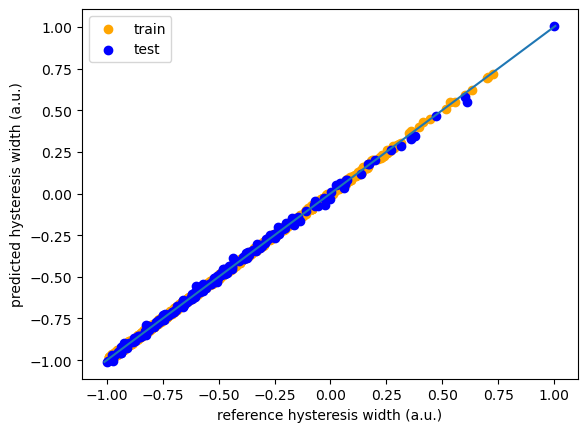

Cross-validation scores [%]: [99.77933862 99.79175562 99.84796798 99.81219414 99.72826903]

Average cross-validation score: 99.79190507960797 %


Training set score: 99.94848883636335 %
Test set score: 99.83273828865288 %
Train data:
RMSE =  0.008177608242121114
MAE =  0.007202820284945752
R2 =  0.9994848883636335
Test data:
RMSE =  0.014242557235504046
MAE =  0.010474341780502397
R2 =  0.9983273828865288


In [6]:
#repeat training with optimized hyperparameters
svr = SVR(C=hyper['C'] ,coef0=hyper['coef0'], degree=hyper['degree'], epsilon=hyper['epsilon'],
          gamma=hyper['gamma'], kernel=hyper['kernel'])

# Cross-Validation
print('--Cross-validation--\n')
kfold=KFold(n_splits=3, shuffle=True, random_state=rndstate)
scores = cross_val_score(svr,X_train,y_train,cv=kfold)*100.0
print('Cross-validation scores [%]: {}\n'.format(scores))
print('Average cross-validation score: {} %\n\n'.format(scores.mean()))

print('training model\n')
# fit training data
svr.fit(X_train, y_train)
# compute traning and test scores and print them to terminal
train_score = 100*svr.score(X_train, y_train)
test_score = 100*svr.score(X_test, y_test)
print("Training set score: {} %".format(train_score))
print("Test set score: {} %".format(test_score))

# store svr for hyteresis width
svr_hw = svr

# graphical output
y_predict_test=svr.predict(X_test)
y_predict_train=svr.predict(X_train)
y_predict = svr.predict(input_data)
y_max = max(y_predict_test)
y_min = min(y_predict_test)
plt.plot([y_min,y_max],[y_min,y_max])

plt.scatter(y_train,y_predict_train,c='orange',label='train')
plt.scatter(y_test,y_predict_test,c='b',label='test')
plt.legend()
plt.xlabel('reference hysteresis width (a.u.)')
plt.ylabel('predicted hysteresis width (a.u.)')
plt.show()

# calculate statistical data for success of training
my_scorer_cv(svr, X_train=X_train, y_train=y_train, exponentiate=False)   
my_scorer_test(svr, X_train=X_train,X_test=X_test, y_train=y_train, y_test=y_test, exponentiate=False)
my_scorer(svr)

# Train SVR for creep length 

## 1. Hyperparameter optimization for SVR with randomized search

In [7]:
#select creep length as label (training target)
output_data = AllData['clength']
''' Preprocessing data '''
rndstate = 40
'Splitting into training and test set'
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, random_state=rndstate)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
svr = SVR()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
svr_random = RandomizedSearchCV(estimator = svr, param_distributions = random_grid,
                               n_iter = 82, cv = 10, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
svr_random.fit(X_train, y_train)
hyper = svr_random.best_params_
hyper

Fitting 10 folds for each of 82 candidates, totalling 820 fits


{'kernel': 'rbf',
 'gamma': 'auto',
 'epsilon': np.float64(0.011090909090909092),
 'degree': 1,
 'coef0': np.float64(0.28354545454545454),
 'C': np.float64(22.223000000000003)}

--Cross-validation--

Cross-validation scores [%]: [95.67710344 95.28518197 96.03049083]

Average cross-validation score: 95.66425874860174 %


training model

Training set score: 99.06044888757741 %
Test set score: 93.1899610927716 %


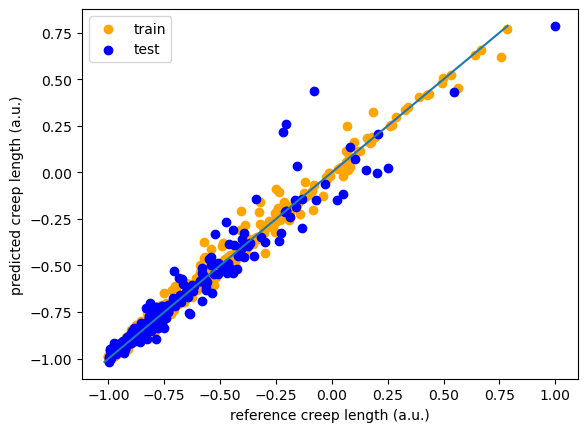

Cross-validation scores [%]: [95.60662807 95.40821465 95.66369614 96.20770084 94.83052731]

Average cross-validation score: 95.54335340101836 %


Training set score: 99.06044888757741 %
Test set score: 93.1899610927716 %
Train data:
RMSE =  0.031013490626532293
MAE =  0.01825117523399723
R2 =  0.9906044888757741
Test data:
RMSE =  0.08120859281959936
MAE =  0.044930327579738014
R2 =  0.931899610927716


In [8]:
svr = SVR(C=hyper['C'] ,coef0=hyper['coef0'], degree=hyper['degree'], epsilon=hyper['epsilon'],
          gamma=hyper['gamma'], kernel=hyper['kernel'])

# Cross-Validation
print('--Cross-validation--\n')
kfold=KFold(n_splits=3, shuffle=True, random_state=rndstate)
scores = cross_val_score(svr,X_train,y_train,cv=kfold)*100.0
print('Cross-validation scores [%]: {}\n'.format(scores))
print('Average cross-validation score: {} %\n\n'.format(scores.mean()))

print('training model\n')
# fit training data
svr.fit(X_train, y_train)
# compute traning and test scores and print them to terminal
train_score = 100*svr.score(X_train, y_train)
test_score = 100*svr.score(X_test, y_test)
print("Training set score: {} %".format(train_score))
print("Test set score: {} %".format(test_score))

# store trained SVR for creep length
svr_cl = svr

#graphical output
y_predict_test=svr.predict(X_test)
y_predict_train=svr.predict(X_train)
y_predict = svr.predict(input_data)
y_max = max(y_predict_test)
y_min = min(y_predict_test)
plt.plot([y_min,y_max],[y_min,y_max])
plt.scatter(y_train,y_predict_train,c='orange',label='train')
plt.scatter(y_test,y_predict_test,c='b',label='test')
plt.legend()
plt.xlabel('reference creep length (a.u.)')
plt.ylabel('predicted creep length (a.u.)')
plt.show()

#calculate statistical data for quality of training
my_scorer_cv(svr, X_train=X_train, y_train=y_train, exponentiate=False)   
my_scorer_test(svr, X_train=X_train,X_test=X_test, y_train=y_train, y_test=y_test, exponentiate=False)
my_scorer(svr)

## 2. Study influence of "wrong" material parameter in feature vector

--Cross-validation--

Cross-validation scores [%]: [95.67710344 95.28518197 96.03049083]

Average cross-validation score: 95.66425874860174 %


training model

Training set score: 99.06044888757741 %
Test set score: 93.1899610927716 %


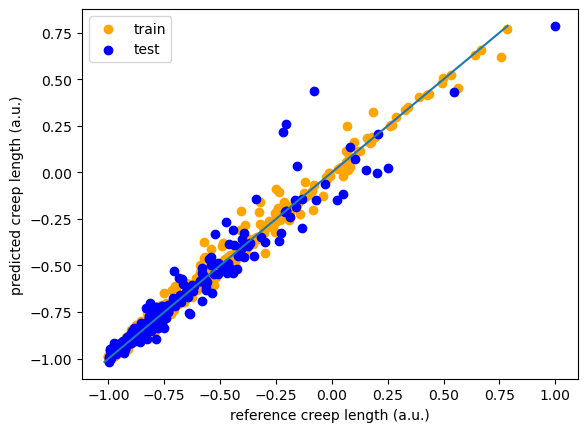

Cross-validation scores [%]: [95.60662807 95.40821465 95.66369614 96.20770084 94.83052731]

Average cross-validation score: 95.54335340101836 %


Training set score: 99.06044888757741 %
Test set score: 93.1899610927716 %
Train data:
RMSE =  0.031013490626532293
MAE =  0.01825117523399723
R2 =  0.9906044888757741
Test data:
RMSE =  0.08120859281959936
MAE =  0.044930327579738014
R2 =  0.931899610927716


In [9]:
# Exchange "A0" against "A" in feature vector
InNames_w = ['n','m','A0','C1', 'g1', 'C2','Q','b']
input_data_w = AllData[InNames_w]

# Preprocessing data
rndstate = 40
# Splitting into training and test set'
X_train, X_test, y_train, y_test = train_test_split(input_data_w, output_data, random_state=rndstate)

#train with optimized hyperparameters
svr = SVR(C=hyper['C'] ,coef0=hyper['coef0'], degree=hyper['degree'], epsilon=hyper['epsilon'],
          gamma=hyper['gamma'], kernel=hyper['kernel'])

# Cross-Validation
print('--Cross-validation--\n')
kfold=KFold(n_splits=3, shuffle=True, random_state=rndstate)
scores = cross_val_score(svr,X_train,y_train,cv=kfold)*100.0
print('Cross-validation scores [%]: {}\n'.format(scores))
print('Average cross-validation score: {} %\n\n'.format(scores.mean()))

print('training model\n')
# fit training data
svr.fit(X_train, y_train)
# compute traning and test scores and print them to terminal
train_score = 100*svr.score(X_train, y_train)
test_score = 100*svr.score(X_test, y_test)
print("Training set score: {} %".format(train_score))
print("Test set score: {} %".format(test_score))

#graphical output
y_predict_test=svr.predict(X_test)
y_predict_train=svr.predict(X_train)
y_predict = svr.predict(input_data)
y_max = max(y_predict_test)
y_min = min(y_predict_test)
plt.plot([y_min,y_max],[y_min,y_max])
plt.scatter(y_train,y_predict_train,c='orange',label='train')
plt.scatter(y_test,y_predict_test,c='b',label='test')
plt.legend()
plt.xlabel('reference creep length (a.u.)')
plt.ylabel('predicted creep length (a.u.)')
plt.show()

#calculate statistical data for quality of training
my_scorer_cv(svr, X_train=X_train, y_train=y_train, exponentiate=False)   
my_scorer_test(svr, X_train=X_train,X_test=X_test, y_train=y_train, y_test=y_test, exponentiate=False)
my_scorer(svr)

# Apply surrogate model for plotting of functional dependencies

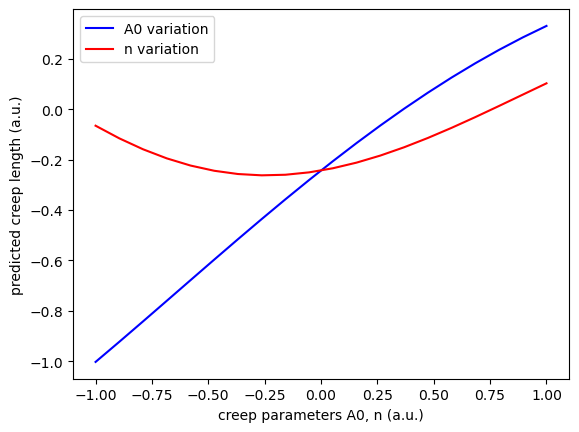

In [10]:
#plot creep length as function of A0
import warnings
warnings.filterwarnings("ignore")
x1 = np.zeros((20,8))  # set all parameters to the average values in scaled parameter space
x1[:,2] = np.linspace(-1,1,20)  # set column for A0 to full variation covered by data
y1 = svr_cl.predict(x1)
x2 = np.zeros((20,8))  # set all parameters to the average values in scaled parameter space
x2[:,0] = np.linspace(-1,1,20)  # set column for A0 to full variation covered by data
y2 = svr_cl.predict(x2)
plt.plot(x1[:,2],y1,'-b',label='A0 variation')
plt.plot(x2[:,0],y2,'-r',label='n variation')
plt.ylabel('predicted creep length (a.u.)')
plt.xlabel('creep parameters A0, n (a.u.)')
plt.legend()
plt.show()

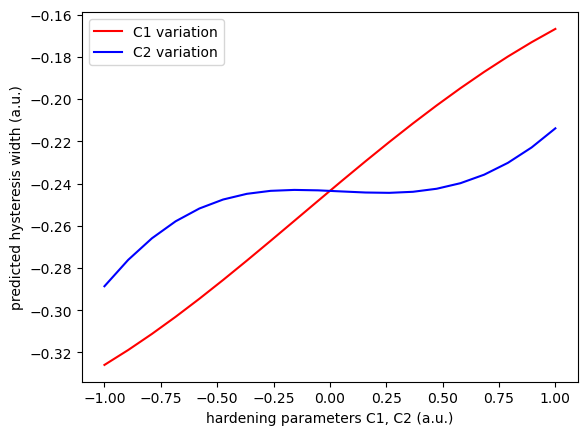

In [12]:
#plot hysteresis width as function of C1 and C2
x1 = np.zeros((20,8))  # set all parameters to the average values in scaled parameter space
x1[:,3] = np.linspace(-1,1,20)  # set column for A0 to full variation covered by data
y1 = svr_cl.predict(x1)
x2 = np.zeros((20,8))  # set all parameters to the average values in scaled parameter space
x2[:,5] = np.linspace(-1,1,20)  # set column for A0 to full variation covered by data
y2 = svr_cl.predict(x2)
plt.plot(x1[:,3],y1,'-r',label='C1 variation')
plt.plot(x2[:,5],y2,'-b',label='C2 variation')
plt.ylabel('predicted hysteresis width (a.u.)')
plt.xlabel('hardening parameters C1, C2 (a.u.)')
plt.legend()
plt.show()